In [1]:
%run -i ./../common/common
%run -i ./zhukovsky
%matplotlib inline

In [13]:
def make_circle(center: Coords, r: float, steps: int = 101) -> Grid:
    x0, y0 = center
    angles = np.linspace(-math.pi, math.pi, steps)
    xs = r * np.cos(angles) + x0
    ys = r * np.sin(angles) + y0
    return (xs, ys)

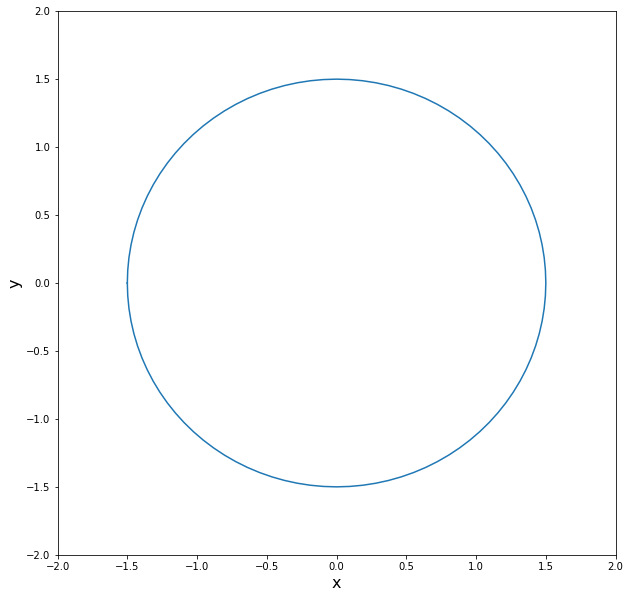

In [19]:
circle = make_circle(Coords(0, 0), 1.5)
size = 10
rect = Rect(-2.0, 2.0, -2.0, 2.0)
setup_fig(rect, size)
plt.plot(*circle)

In [21]:
def zhukovsky_to_shape(grid: Grid, c: complex) -> Grid:
    xs, ys = grid
    zxs = np.fromiter(map(lambda x, y: zhukovsky(complex(x, y), c).real, xs, ys), xs.dtype)
    zys = np.fromiter(map(lambda x, y: zhukovsky(complex(x, y), c).imag, xs, ys), xs.dtype)
    return (zxs, zys)

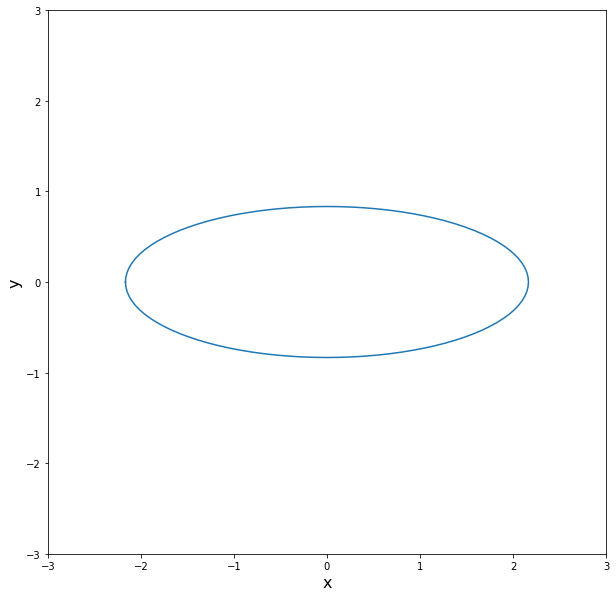

In [23]:
transformed = zhukovsky_to_shape(circle, 1.0 + 0.0j)
rect = Rect(-3.0, 3.0, -3.0, 3.0)
setup_fig(rect, size)
plt.plot(*transformed)

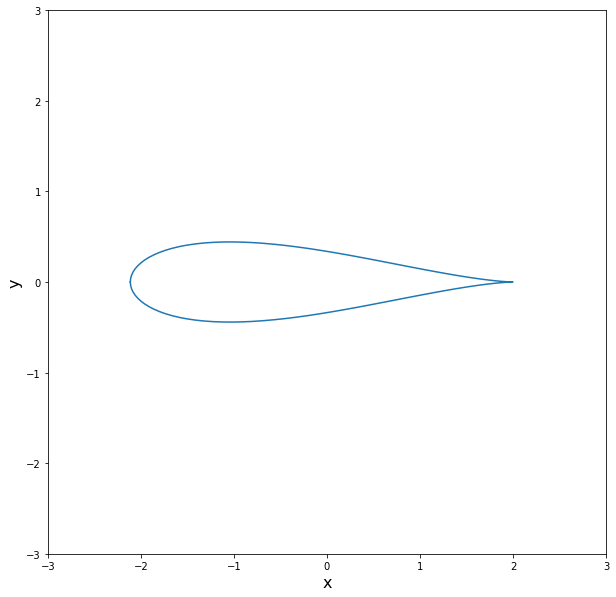

In [25]:
r = 1.2
c = 1.0 + 0.0j
center = Coords(c.real - r, 0.0)
circle = make_circle(center, r)
transformed = zhukovsky_to_shape(circle, c)

size = 10
rect = Rect(-3.0, 3.0, -3.0, 3.0)
setup_fig(rect, size)
plt.plot(*transformed)

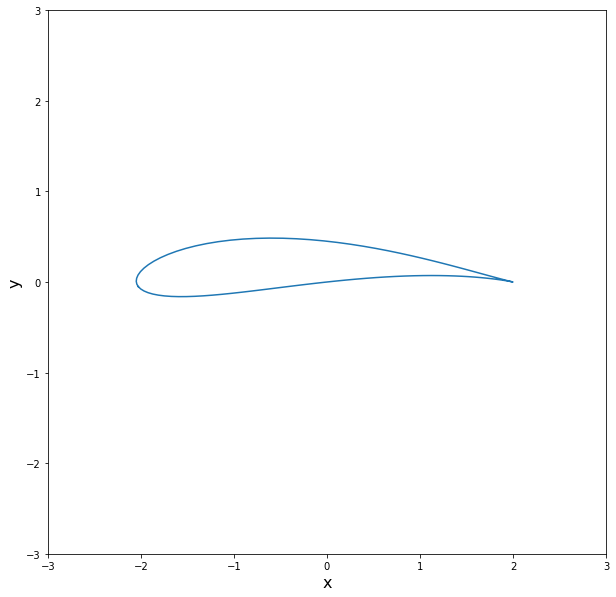

In [39]:
c = 1.0 + 0.0j
center = Coords(0.1, 0.1)
r = math.sqrt((c.real - center.x)**2 + center.y**2)
circle = make_circle(center, r)
transformed = zhukovsky_to_shape(circle, c)

setup_fig(rect, size)
plt.plot(*transformed)